# Improt modules

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm, trange
import random
import segmentation_models_pytorch as smp

In [3]:
import torch
import torchvision
import albumentations
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load dataset files

In [4]:
def list_files(path, ext=None):
    result = []
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        if ext is not None:
            if not full_path.endswith(ext):
                continue
        result.append(full_path)
    return result

In [5]:
f1024i_folder = '/landcover_czech_5120_z16_first_1024/farmland_czech_5120_z16_first_1024'
f512m_folder = '/landcover_czech_5120_z16_first_512_inf'
f1024m_folder = '/landcover_czech_5120_z16_first_1024_inf'

image_path_list = []
image_path_list.extend(list_files(f1024i_folder))
print(len(image_path_list))

mask_path_list = []
mask_path_list.extend(list_files(f512m_folder))
mask_path_list.extend(list_files(f1024m_folder))
print(len(mask_path_list))

1024
1024


In [6]:
f256i2_folder = '/extra256/u256_1'
f256m2_folder = '/extra256_inf'

f2_image_path_list = []
f2_image_path_list.extend(list_files(f256i2_folder))
print(len(f2_image_path_list))

f2_mask_path_list = []
f2_mask_path_list.extend(list_files(f256m2_folder))
print(len(f2_mask_path_list))

256
256


In [7]:
train_augumentations = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.50),
    albumentations.RandomRotate90(p=0.75),
    albumentations.Rotate(limit=45, p=1),
    albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
    albumentations.RGBShift(),
    albumentations.HueSaturationValue(p=1),
    albumentations.ChannelShuffle(p=0.2),
    albumentations.RandomGamma(p=1),
    albumentations.Perspective(p=0.25),
    albumentations.OneOf([
        albumentations.MedianBlur(blur_limit=3, p=1),
        albumentations.MotionBlur(blur_limit=3, p=1), 
        albumentations.Blur(),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.GaussNoise(),
        albumentations.Sharpen (alpha=(0.05, 0.1), lightness=(0.1, 0.5), p=0.5),
    ], p=0.5),
    albumentations.PadIfNeeded(min_height=768, min_width=768, always_apply=True, border_mode=0),
    albumentations.RandomCrop(height=768, width=768, always_apply=True),
    ])

valid_augumetations = albumentations.Compose([
        albumentations.PadIfNeeded(min_height=768, min_width=768, always_apply=True, border_mode=0),
        albumentations.CenterCrop(height=768, width=768, always_apply=True),
    ])

In [8]:
class SamDataset(Dataset):
    def __init__(self, images_path, masks_path_list, aug=None):
        self.images_path = images_path
        self.masks_path_list = masks_path_list
        self.erosion_kernel = np.ones((11, 11), np.uint8)
        self.aug = aug
        self.memcache = {}
        
    def __getitem__(self, i):
        if i in self.memcache:
            image, mask = self.memcache[i]
        else:
            masks_path = self.masks_path_list[i]
            masks_files = list_files(masks_path, ext=None)
            name = os.path.basename(masks_path)
            image_path = os.path.join(self.images_path, name + '.tif')

            image = cv2.imread(image_path)
            h, w, _ = image.shape
            resulting_mask = np.zeros((h, w), dtype=np.uint8)
            resulting_borders = np.zeros((h, w), dtype=np.uint8)
            for fn in masks_files:
                mask = cv2.imread(fn).clip(0, 1)[..., 0]
                negative_mask = np.ones_like(mask) - mask.clip(0, 1)
                resulting_mask = resulting_mask * negative_mask
                resulting_mask += mask

                mask_erode = cv2.erode(mask, self.erosion_kernel, iterations=1)
                mask_erode = (mask_erode > 0).astype(np.uint8)
                edge_mask = mask - mask_erode
                resulting_borders += edge_mask

            resulting_borders = (resulting_borders > 0).astype(np.uint8)
            mask = resulting_borders
            self.memcache[i] = (image, mask)
        
        if self.aug is not None:
            sample = self.aug(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return {'image': image, 'mask': mask.astype(np.float32)}
    
    def __len__(self):
        return len(self.masks_path_list)

In [9]:
class ComboDataset(Dataset):
    def __init__(
        self, 
        datasets,
        aug=None, 
    ):
        self.datasets = datasets
        self.aug = aug
    
    def __getitem__(self, i):
        image, mask = None, None
        pos = 0
        for d in self.datasets:
            if i >= (pos +len(d)):
                pos += len(d)
                continue
            else:
                return d[i -pos]
        
    def __len__(self):
        return sum([len(i) for i in self.datasets])

In [10]:
# First 768 for training
train_f1_ds = SamDataset(f1024i_folder, mask_path_list[:768], train_augumentations)
train_f2_ds = SamDataset(f256i2_folder, f2_mask_path_list, train_augumentations)
train_ds = ComboDataset([train_f1_ds, train_f2_ds])

# Last 256 for validation
test_ds = SamDataset(f1024i_folder, mask_path_list[768:], valid_augumetations)

671
uint8 (768, 768, 3) float32 (768, 768)


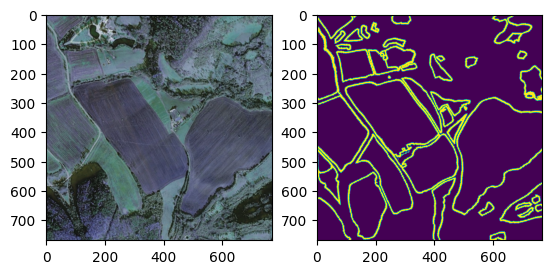

In [11]:
n = random.randint(0, len(train_ds) -1)
i = train_ds[n]
image, mask = i['image'], i['mask']

print(n)
print(image.dtype, image.shape, mask.dtype, mask.shape)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image.astype(np.uint8))
axarr[1].imshow(mask)
plt.show()

# Setup model and run training

In [12]:
# Based on https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

class DiceLoss(torch.nn.Module):
    def __init__(self, k=2, smooth=0.0, eps=1e-7, weight=None, size_average=True):
        self.k = k
        self.smooth = smooth
        self.eps = eps
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (self.k*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth + self.eps)  
        
        return 1 - dice

In [13]:
CUDA = "cuda:0"
CPU = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NET = smp.create_model(
    "Linknet", encoder_name='mobileone_s2',
    in_channels=3, classes=1
)

NET.to(device)
NET.load_state_dict(torch.load('/kaggle/input/u256-1/mobileone_best.pth.24.pth', map_location=device))


BATCH_SIZE = 4
EPOCH_COUNT = 6
CRITERION = DiceLoss(k=4)
OPTIMIZER = torch.optim.Adam(NET.parameters(), lr=0.000033)

TRAIN_LOADER = torch.utils.data.DataLoader(train_ds,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=2)
VALID_LOADER = torch.utils.data.DataLoader(test_ds,
                                           batch_size=1,
                                           shuffle=False, num_workers=2)

SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER,
                                                       mode='min', factor=0.25,
                                                       patience=10)

LOSS_PRINT_STEP = 1
BEST_PATH = '/kaggle/working/best.pth'


EPOCH_KEY = 'EPOCH'
BATCH_KEY = 'BATCH'
LOSS_KEY = 'LOSS'
VAL_LOSS_KEY = 'VAL_LOSS'
VAL_IOU_KEY = 'VAL_IOU'

# Evaluate batch
def shared_step(batch, train=True):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = batch['image'], batch['mask']
    inputs, labels = inputs.to(device).permute(0, 3, 1, 2) / 255, labels.to(device)

    # zero the parameter gradients
    if train:
        OPTIMIZER.zero_grad()

    # forward + backward + optimize
    outputs = NET(inputs)
    loss = CRITERION(outputs, labels.float())
    if train:
        loss.backward()
        OPTIMIZER.step()
  
    return loss, outputs, labels


train_history = []
history = []
best_score = float('inf')
not_increase_count = 0
max_not_increase = 10
for epoch in range(1, EPOCH_COUNT+1):

    # Training
    train_count = len(TRAIN_LOADER)
    with tqdm(TRAIN_LOADER, position=0) as train_data_iterator:
        for batch_n, data in enumerate(train_data_iterator, 1):
            progress_update = False
            NET.train()
            loss, outputs, labels = shared_step(data)

            train_history.append({LOSS_KEY: float(loss)})
            # print statistics
            history_item = {EPOCH_KEY: epoch,
                            BATCH_KEY: batch_n,
                            LOSS_KEY: float(loss)}
            train_history.append(history_item)
            if batch_n == 1 or batch_n % LOSS_PRINT_STEP == 0:
                train_data_iterator.set_postfix(history_item)

    # Validation
    total_iou = 0
    total_valid_loss = 0
    with tqdm(VALID_LOADER, position=0) as valid_data_iterator:
        for batch_n, data in enumerate(valid_data_iterator, 1):   
            with torch.no_grad():
                NET.eval()
                loss, outputs, labels = shared_step(data, train=False)

            total_valid_loss += float(loss)
            
            prob_mask = outputs.sigmoid()
            pred_mask = (prob_mask > 0.5).float()
            
            pred_mask = torch.squeeze(pred_mask)
            labels = torch.squeeze(labels)
        
            tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), labels.long(), mode="binary")
            per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
            total_iou += float(per_image_iou)

        # Stat valid results
        avg_valid_loss = total_valid_loss / len(VALID_LOADER)
        avg_valid_iou = total_iou / len(VALID_LOADER)
        
        history_item = {EPOCH_KEY: epoch}
        history_item[VAL_LOSS_KEY] = avg_valid_loss
        history_item[VAL_IOU_KEY] = avg_valid_iou
        
        _ = [print(f'{key} = {value}') for key, value in history_item.items()]
        history.append(history_item)
        
        SCHEDULER.step(avg_valid_loss)
        if avg_valid_loss < best_score:
            best_score = avg_valid_loss
            torch.save(NET.state_dict(), f'{BEST_PATH}.{str(epoch)}.pth')
            not_increase_count = 0
        else:
            not_increase_count += 1
        torch.save(NET.state_dict(), f'/kaggle/working/{str(epoch)}.pth')
        torch.save(OPTIMIZER.state_dict(), f'/kaggle/working/{str(epoch)}.o.pth')

    print('not_increase_count', not_increase_count)
    if not_increase_count == max_not_increase:
        break
    
    fields = [i for i in history[0].keys()]
    with open('/kaggle/working/history.csv', 'w', newline='') as f: 
        writer = csv.DictWriter(f, fieldnames = fields)
        writer.writeheader() 
        writer.writerows(history)

print('\nTraining fininshed!')

Downloading: "https://docs-assets.developer.apple.com/ml-research/datasets/mobileone/mobileone_s2_unfused.pth.tar" to /root/.cache/torch/hub/checkpoints/mobileone_s2_unfused.pth.tar
100%|██████████| 30.6M/30.6M [00:00<00:00, 114MB/s]
100%|██████████| 256/256 [02:07<00:00,  2.01it/s]


EPOCH = 1
VAL_LOSS = -0.3885494046844542
VAL_IOU = 0.5373042384162545
not_increase_count 0


100%|██████████| 256/256 [01:32<00:00,  2.76it/s]


EPOCH = 2
VAL_LOSS = -0.3901713874656707
VAL_IOU = 0.5383516538422555
not_increase_count 0


100%|██████████| 256/256 [01:31<00:00,  2.80it/s]


EPOCH = 3
VAL_LOSS = -0.3894488422665745
VAL_IOU = 0.5373810027958825
not_increase_count 1


100%|██████████| 256/256 [01:31<00:00,  2.80it/s]


EPOCH = 4
VAL_LOSS = -0.39463267172686756
VAL_IOU = 0.5401853451039642
not_increase_count 0


100%|██████████| 256/256 [01:31<00:00,  2.80it/s]


EPOCH = 5
VAL_LOSS = -0.3961403579451144
VAL_IOU = 0.541163633344695
not_increase_count 0


100%|██████████| 256/256 [01:31<00:00,  2.81it/s]


EPOCH = 6
VAL_LOSS = -0.3966946476139128
VAL_IOU = 0.5412166167516261
not_increase_count 0

Training fininshed!


# Visualize metrics and results

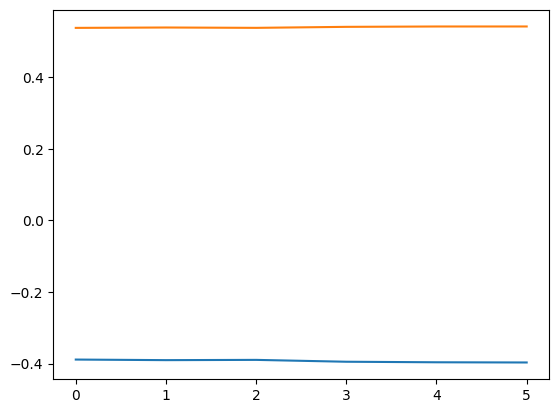

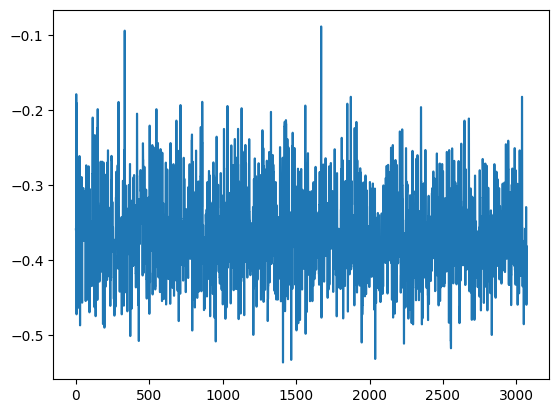

In [14]:
plt.plot([float(i[VAL_LOSS_KEY]) for i in history])
plt.plot([float(i[VAL_IOU_KEY]) for i in history])
plt.show()
plt.plot([float(i[LOSS_KEY]) for i in train_history])
plt.show()

434
uint8 (768, 768, 3) float32 (768, 768)


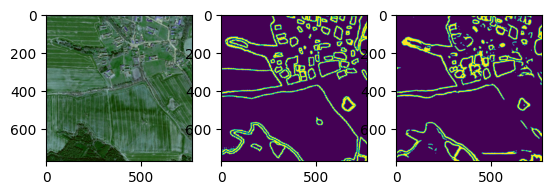

In [15]:
n = random.randint(0, len(train_ds) -1)
i = train_ds[n]
image, mask = i['image'], i['mask']

print(n)
print(image.dtype, image.shape, mask.dtype, mask.shape)
NET = NET.eval()
image_t = torch.unsqueeze(torch.from_numpy(image), dim=0).permute(0, 3, 1, 2).cuda() / 255
pred = torch.squeeze(NET(image_t).sigmoid()).detach().cpu().numpy()

f, axarr = plt.subplots(1,3)
axarr[0].imshow(image.astype(np.uint8))
axarr[1].imshow(mask)
axarr[2].imshow(pred)
plt.show()